In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from skimage.measure import block_reduce
import pickle
import torch

from scipy.stats import skew, kurtosis
from sklearn.linear_model import LinearRegression
from scipy.ndimage import gaussian_filter as gf
from torch.nn.functional import pad

from morans import morans

In [2]:
# Create a square 2D Ising Lattice 
# Initial magnetization state of the elements in the lattice is uniform (u) or randomized (r)

class IsingLattice:

    def __init__(self, initial_state, size, J, mask = None, h=0):
        self.size = size # size of each dimension
        

        if J is np.ndarray:
            self.J = J
        else:
            self.J = J*np.ones((size,size))
        self.h = h*np.ones((self.size,self.size)) # array of (size,size)
        
        self.system = self._build_system(initial_state)

        if mask is None:
            self.mask = np.ones((size,size))
        else:
            self.mask = mask

        # self.T = temperature*np.ones((self.size,self.size)) # array of (size,size)
        # self.k = 1.38 * (10**(-23))

    @property
    def sqr_size(self):
        return (self.size, self.size)

    def _build_system(self, initial_state):
        """Build the system

        Build either a randomly distributed system or a homogeneous system (for
        watching the deterioration of magnetization

        Parameters
        ----------
        initial_state : str: "r" for random or "u" for uniform (all +1)
            Initial state of the lattice. 
        """

        if initial_state == 'r':
            system = np.random.choice([-1, 1], self.sqr_size)
        elif initial_state == 'u':
            system = np.ones(self.sqr_size)
        else:
            raise ValueError(
                "Initial State must be 'r', random, or 'u', uniform"
            )

        return system
    
    def _bc(self, i):
        """Apply periodic boundary condition

        Check if a lattice site coordinate falls out of bounds. If it does,
        apply periodic boundary condition

        Assumes lattice is square

        Parameters
        ----------
        i : int
            lattice site coordinate

        Return
        ------
        int
            corrected lattice site coordinate
        """
        if i >= self.size:
            return 0
        if i < 0:
            return self.size - 1
        else:
            return i

    def energy(self, N, M):
        """Calculate the energy of spin interaction at a given lattice site
        i.e. the interaction of a Spin at lattice site n,m with its 4 neighbors

        - S_n,m*(S_n+1,m + Sn-1,m + S_n,m-1, + S_n,m+1)

        Parameters
        ----------
        N : int
            lattice site coordinate
        M : int
            lattice site coordinate

        Return
        ------
        float
            energy of the site
        """
        interactions = -self.system[N, M]*self.J[N,M]*(self.system[self._bc(N - 1), M] + self.system[self._bc(N + 1), M]+ self.system[N, self._bc(M - 1)] + self.system[N, self._bc(M + 1)])
        external = -self.system[N, M]*self.h[N,M]
        energy = interactions + external
        return energy
    
    @property
    def internal_energy(self):
        e = 0
        E = 0
        E_2 = 0

        for i in range(self.size):
            for j in range(self.size):
                e = self.energy(i, j)
                E += e
                E_2 += e**2

        U = (1./self.size**2)*E
        U_2 = (1./self.size**2)*E_2

        return U, U_2

    @property
    def heat_capacity(self,temp):
        U, U_2 = self.internal_energy
        return np.mean((U_2 - U**2)/np.power(temp,2))

    @property
    def magnetization(self):
        """Find the overall magnetization of the system
        """
        return np.sum(self.system)/self.size**2   #Maybe get rid of abs or add it
    
def hc(lattice,temp):
    U, U_2 = lattice.internal_energy
    return np.mean((U_2 - U**2)/np.power(temp,2))

def create_params():
    try:
        rng = np.random.default_rng()
    except AttributeError:
        rng = np.random.RandomState()


    J_mean = 2**(5*rng.uniform())  # why 5? can choose something else
    J_std = 0.3*rng.uniform()*J_mean # 0 - 30% of mean

    #J = J_mean*np.ones((size,size)) + J_std*(np.random.randn(size,size))

    Tc = 2*J_mean/(np.log(1+np.sqrt(2))) # critical temperature

    null = rng.choice([0,1])

    offset_dir =rng.choice([-1,1])
    spatial_coarse_graining = rng.choice(np.arange(3,8))
    #temporal_coarse_graining = rng.choice(np.arange(3,8))
    #spatial_coarse_graining = 1
    temporal_coarse_graining = 1
    epoch_len = 5000

    if null: # No Transition run (does not go through Tc)
        Tb1 = Tc * (0.2 + 0.2*rng.uniform())
        Tb2 = Tc * (0.4 + 0.2*rng.uniform())
            
        Tbounds = Tc + offset_dir*np.array([Tb1,Tb2])
        Tbounds = rng.permutation(Tbounds)

    else: # Transition Run (goes through Tc)
        Tb1 = Tc * (0.7 - 0.4*rng.uniform())
        Tb2 = Tc * (1.2 + 0.4*rng.uniform())
        #Tbounds = np.sort(np.array([Tb1,Tb2]))[::-1] # descending order, why ?? *******************
        Tbounds = rng.choice(([[Tb1,Tc],[Tc,Tb2]]))
        Tbounds = rng.permutation(Tbounds)
    
    target_duration = rng.choice(list(range(575,675)))


    run_params = {'J_mean':J_mean, 'J_std':J_std, 'Tc':Tc, 
                    'spatial_coarse_graining':spatial_coarse_graining,
                    'temporal_coarse_graining':temporal_coarse_graining,
                    'epoch_len':epoch_len, 'null':null,'Tbounds':Tbounds,'target_duration':target_duration}
    

    return run_params



def run(lattice, temps,burn_time , epoch_len = 10000):
    """Run the simulation
    """
    # System = []
    # Magnetization = []
    # Heat_Capacity = []
    epochs = temps.shape[0]

    System = np.zeros((epochs,lattice.system.shape[0],lattice.system.shape[1]))
    Magnetization = np.zeros(epochs)
    Heat_capacity = np.zeros(epochs)

    for epoch,temp in enumerate(temps):    

        step_avg = np.zeros((lattice.size,lattice.size)) # why are we taking step average

        for step in range(epoch_len):
            # Randomly select a site on the lattice
            N, M = np.random.randint(0, lattice.size, 2)

            # Calculate energy of a flipped spin
            dE = -2*lattice.energy(N, M)

            # "Roll the dice" to see if the spin is flipped
            if dE <= 0.:
                lattice.system[N, M] *= -1
            elif np.exp(-dE/(temp)) > np.random.rand():
                lattice.system[N, M] *= -1

            step_avg += lattice.system

        step_avg = step_avg/epoch_len

        # check and account for burn time (write an if statement)
        System[epoch,:,:] = step_avg
        Magnetization[epoch] = lattice.magnetization
        Heat_capacity[epoch] = hc(lattice,temp)

        #System.append(step_avg)
        #Magnetization.append(lattice.magnetization) #should we not take average magnetization?
        #Heat_Capacity.append(lattice.heat_capacity(temp=temp))

        output= {"System":System,"Magnetization":Magnetization,"Heat_capacity":Heat_capacity}

    return output



def ising_run(temps, size, J, burn_time, epoch_len, initial_state):
    
    
    lattice = IsingLattice(initial_state=initial_state, size=size, J=J)
    out_vars = run(lattice=lattice, temps=temps, burn_time=burn_time, epoch_len=epoch_len)

    return out_vars


def matrix_autocorr(s_flatten,lag):
    sbar = np.mean(s_flatten,axis=0)
    s_full = s_flatten - np.tile(sbar,(s_flatten.shape[0],1))
    
    s_0 = s_full[:s_flatten.shape[0]-lag,:]
    s_shift = s_full[lag:s_flatten.shape[0],:]
    
    ac_num = np.nansum(np.multiply(s_0,s_shift),axis=0)
    ac_denom = np.nansum(np.multiply(s_full,s_full),axis=0)
    
    ac = np.divide(ac_num,ac_denom)
    
    return ac



def temporal_ews(s,t_roll_window):
    s = s.reshape(s.shape[0],-1)
    
    t_var = np.zeros(s.shape)
    t_skew = np.zeros(s.shape)
    t_kurt = np.zeros(s.shape)
    t_corr_1 = np.zeros(s.shape)
    t_corr_2 = np.zeros(s.shape)
    t_corr_3 = np.zeros(s.shape)
    
    for j in range(s.shape[0]-t_roll_window):
        window_end = j+t_roll_window
        s_window = s[j:window_end,:]
        
        t_var[window_end,:] = np.nanvar(s_window,axis=0)
        t_skew[window_end,:] = skew(s_window,axis=0,nan_policy='omit')
        t_kurt[window_end,:] = kurtosis(s_window,axis=0,nan_policy='omit')
        
        t_corr_1[window_end,:] = matrix_autocorr(s_window,1)
        t_corr_2[window_end,:] = matrix_autocorr(s_window,2)
        t_corr_3[window_end,:] = matrix_autocorr(s_window,3)

    
    return {'t_var':t_var,
            't_skew':t_skew,
            't_kurt':t_kurt,
            't_corr_1':t_corr_1,
            't_corr_2':t_corr_2,
            't_corr_3':t_corr_3}



def compute_ews(s,t_roll_window):
    # s has dims [t,x,y]
    #
    # for gaussian filter, smooth param is sigma in [temporal,spatial] dimensions
    #
    # as of now filter is only applied when computing temporal EWS -> if smooth_param[1] != 0,
    # this will need to be reimplemented to achieve desired behavior
    
    # Temporal EWS:
    #t_roll_window = int(np.floor(t_roll_window_frac*s.shape[0]))
    
    t_ews = temporal_ews(s,t_roll_window)
    
   

    t_var = np.nanmean(t_ews['t_var'],axis=1)
    t_skew = np.nanmean(t_ews['t_skew'],axis=1)
    t_kurt = np.nanmean(t_ews['t_kurt'],axis=1)
    t_corr_1 = np.nanmean(t_ews['t_corr_1'],axis=1)
    t_corr_2 = np.nanmean(t_ews['t_corr_2'],axis=1)
    t_corr_3 = np.nanmean(t_ews['t_corr_3'],axis=1)
    
    # Spatial EWS:
    s_flatten = s.reshape(s.shape[0],-1)
    s_flatten = s_flatten[t_roll_window:,:]
    
    x_var = np.zeros(s.shape[0])
    x_skew = np.zeros(s.shape[0])
    x_kurt = np.zeros(s.shape[0])
    x_corr_1 = np.zeros(s.shape[0])
    x_corr_2 = np.zeros(s.shape[0])
    x_corr_3 = np.zeros(s.shape[0])
    
    x_var[t_roll_window:] = np.nanvar(s_flatten,axis=1)
    x_skew[t_roll_window:] = skew(s_flatten,axis=1,nan_policy='omit')
    x_kurt[t_roll_window:] = kurtosis(s_flatten,axis=1,nan_policy='omit')

    
    x_corr_1[t_roll_window:] = morans(s[t_roll_window:,:,:],1,periodic=False)
    x_corr_2[t_roll_window:] = morans(s[t_roll_window:,:,:],2,periodic=False)
    x_corr_3[t_roll_window:] = morans(s[t_roll_window:,:,:],3,periodic=False)
    
    x = np.vstack((t_var,t_skew,t_kurt,t_corr_1,t_corr_2,t_corr_3,
                   x_var,x_skew,x_kurt,x_corr_1,x_corr_2,x_corr_3))
    
    return x.T
            

In [3]:
n_runs = 10
burn_time = 50
target_size = 15
#target_duration = 400

#Output=pd.DataFrame(columns=["System","System_cg","Magnetization","Heat_capacity","null"])
Result=pd.DataFrame(columns=["System","System_cg","System_ews","Magnetization","Heat_capacity","Tc","Tbounds","null"])


for r in range(n_runs):

    print(f"Run {r}")
    params = create_params()
    J_mean = params["J_mean"]
    J_std = params["J_std"]
    Tc = params["Tc"]
    spatial_coarse_graining = params["spatial_coarse_graining"]
    temporal_coarse_graining = params["temporal_coarse_graining"]
    epoch_len = params["epoch_len"]
    null = params["null"]
    Tbounds = params["Tbounds"]
    target_duration = params["target_duration"]

    sim_size = target_size*spatial_coarse_graining
    sim_duration = target_duration*temporal_coarse_graining
    #sim_burn_time = burn_time*temporal_coarse_graining
    temps = np.linspace(Tbounds[0],Tbounds[1],sim_duration-(null*100))

    if temps[0] > Tc:
        initial_state = 'r'
    else:
        initial_state = 'u'


    if not null:
        if (Tbounds[0]>=Tc and Tbounds[0]>=Tc):
            temps = temps[-50::]
            initial_state = 'r'
        else:
            temps = temps[:-50:]
            initial_state = 'u'



    J = J_mean*np.ones((sim_size,sim_size)) + J_std*(np.random.randn(sim_size,sim_size))
    

    output = ising_run(temps,sim_size,J,burn_time,epoch_len,initial_state)

    System = output["System"]
    Magnetization = output["Magnetization"]
    Heat_capacity = output["Heat_capacity"]

    System_cg = block_reduce(System,block_size=(temporal_coarse_graining,spatial_coarse_graining,spatial_coarse_graining),func=np.nanmean)

    #output["System_cg"] = System_cg
    #output["null"] = null

    rng = np.random.default_rng()
    t_roll_window = 150 + rng.integers(low = -50, high = 50)

    System_ews = compute_ews(System_cg,t_roll_window)
    ews = torch.from_numpy(System_ews)

    t = 0
    try:
        while torch.equal(ews[t],torch.zeros(12)):
            t += 1
        System_EWS = ews[t:,:].numpy()
        Result.loc[len(Result.index)] = [System,System_cg,System_EWS,Magnetization,Heat_capacity,Tc,Tbounds,null]
    except IndexError:
        pass
    
    #out = pd.DataFrame(({"System":System,"System_cg":System_cg,"Magnetization":Magnetization,"Heat_capacity":Heat_capacity,"null":null}))
    #out = pd.DataFrame(output)
    
    #Result = pd.concat((Result,out),axis=0,ignore_index=True)


Run 0
Run 1
Run 2
Run 3
Run 4


C:\Users\ebadi\AppData\Local\Temp\ipykernel_13372\3167660021.py:271: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_skew[window_end,:] = skew(s_window,axis=0,nan_policy='omit')
C:\Users\ebadi\AppData\Local\Temp\ipykernel_13372\3167660021.py:272: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_kurt[window_end,:] = kurtosis(s_window,axis=0,nan_policy='omit')
C:\Users\ebadi\AppData\Local\Temp\ipykernel_13372\3167660021.py:250: RuntimeWarning: invalid value encountered in divide
  ac = np.divide(ac_num,ac_denom)
C:\Users\ebadi\AppData\Local\Temp\ipykernel_13372\3167660021.py:322: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unr

Run 5


C:\Users\ebadi\AppData\Local\Temp\ipykernel_13372\3167660021.py:271: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_skew[window_end,:] = skew(s_window,axis=0,nan_policy='omit')
C:\Users\ebadi\AppData\Local\Temp\ipykernel_13372\3167660021.py:272: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_kurt[window_end,:] = kurtosis(s_window,axis=0,nan_policy='omit')
C:\Users\ebadi\AppData\Local\Temp\ipykernel_13372\3167660021.py:250: RuntimeWarning: invalid value encountered in divide
  ac = np.divide(ac_num,ac_denom)


Run 6
Run 7
Run 8
Run 9


C:\Users\ebadi\AppData\Local\Temp\ipykernel_13372\3167660021.py:271: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_skew[window_end,:] = skew(s_window,axis=0,nan_policy='omit')
C:\Users\ebadi\AppData\Local\Temp\ipykernel_13372\3167660021.py:272: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_kurt[window_end,:] = kurtosis(s_window,axis=0,nan_policy='omit')
C:\Users\ebadi\AppData\Local\Temp\ipykernel_13372\3167660021.py:250: RuntimeWarning: invalid value encountered in divide
  ac = np.divide(ac_num,ac_denom)


In [4]:
with open("Train_Data_test","wb") as file:
    pickle.dump(Result,file)

In [5]:
Result

,System,System_cg,System_ews,Magnetization,Heat_capacity,Tc,Tbounds,null
0,"[[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0...","[[[1.0, 0.9908571428571429, 0.9808897959183673...","[[0.0032392501442056534, -1.4633423495584055, ...","[0.9914739229024944, 0.9824036281179138, 0.979...","[0.6500765745883083, 0.7472017099776049, 0.782...",6.236788,"[3.98854715806314, 6.23678752898753]",0
1,"[[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0...","[[[1.0, 0.9656, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[[0.001980815989360143, -3.325040402232634, 12...","[0.9833333333333333, 0.9783333333333334, 0.976...","[0.2234746991307172, 0.29548352078793944, 0.34...",11.877845,"[8.542947376439002, 5.123716451177343]",1
2,"[[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0...","[[[1.0, 1.0, 1.0, 0.8943666666666665, 1.0, 0.9...","[[0.005925360327899036, -1.3735274885912958, 1...","[0.98, 0.9646913580246913, 0.9520987654320988,...","[0.5457683836520829, 0.6593948821393063, 0.736...",29.556786,"[22.79482226098858, 13.431887599339419]",1
3,"[[[-1.0, 0.4168, 1.0, 0.844, 1.0, 1.0, -1.0, -...","[[[0.08608979591836737, 0.1663673469387755, -0...","[[0.08162139325503141, -0.014926508464050652, ...","[-0.0254875283446712, -0.02113378684807256, -0...","[0.4820129782364334, 0.48971204363399495, 0.49...",11.868940,"[15.348899714910171, 17.353851077756982]",1
4,"[[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0...","[[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0...","[[0.0004905051469903552, -5.657957270373362, 3...","[0.9983333333333333, 0.9961111111111111, 0.997...","[0.0647255526817815, 0.12649418335551774, 0.08...",10.807099,"[5.768182259627045, 8.471869545229803]",1


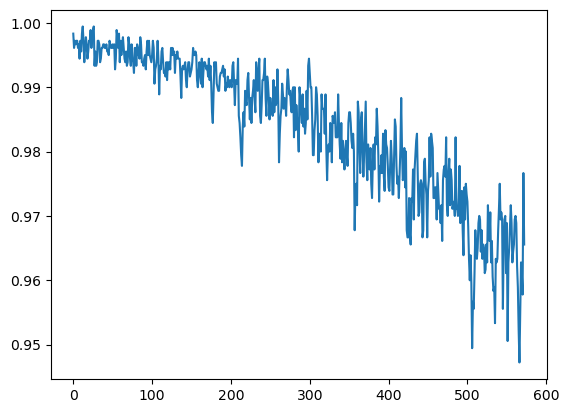

In [6]:
mag=Result["Magnetization"][4]
plt.plot(mag);

In [7]:
stats = Result["System_ews"][4]

In [8]:
mag.shape, stats.shape

((573,), (428, 12))

In [9]:
stats[:,1]

array([-5.65795727, -5.62149577, -5.62077282, -5.61195333, -5.59585098,
       -5.58563456, -5.57654213, -5.54457207, -5.54508004, -5.52900969,
       -5.52058274, -5.52599133, -5.5080165 , -5.49386788, -5.51809574,
       -5.48841595, -5.46302307, -5.45553845, -5.42886809, -5.41014282,
       -5.41325398, -5.41697268, -5.40392754, -5.39280031, -5.39444896,
       -5.37905502, -5.36067253, -5.32650948, -5.31350421, -5.30335082,
       -5.30640088, -5.27835821, -5.27288924, -5.25800629, -5.23485876,
       -5.22616586, -5.19066054, -5.18346956, -5.1651998 , -5.14985198,
       -5.13558848, -5.1474499 , -5.14290738, -5.14022705, -5.13657531,
       -5.1381868 , -5.13759736, -5.1238542 , -5.10581464, -5.11883989,
       -5.13317682, -5.09217472, -5.07764583, -5.05767806, -4.99326885,
       -4.99545288, -4.95056438, -4.92751947, -4.91695789, -4.91684806,
       -4.91281656, -4.88895792, -4.91446571, -4.8821431 , -4.85276578,
       -4.82967364, -4.80750092, -4.81557806, -4.83104472, -4.80